In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")

from helper import read_multi_model_compatibility_data

### Reading compatibility data

In [2]:
# directory with data
data_dir = "/project/fudenber_735/akitaX1_analyses_data/virtual_insertion_flank_core_compatibility"

df = read_multi_model_compatibility_data(data_dir)

/home1/smaruj/akitaX1-analyses/experiments/virtual_insertion_flank_core_compatibility/analysis/helper.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{stat}_m{model_index}_bg{bg_index}"] = df_stat[f"{stat}_m{model_index}_bg{bg_index}"]
/home1/smaruj/akitaX1-analyses/experiments/virtual_insertion_flank_core_compatibility/analysis/helper.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{stat}_m{model_index}_bg{bg_index}"] = df_stat[f"{stat}_m{model_index}_bg{bg_index}"]
/home1/smaruj/akitaX1-analyses/experiments

### Matrix sorted by insertion score of cores and flanks

In [3]:
df = df.drop(columns=[f"SCD_m{m_ind}_bg{bg_ind}" for m_ind in range(4) for bg_ind in range(10)])
df = df.drop(columns=[f"INS-16_m{m_ind}_bg{bg_ind}" for m_ind in range(4) for bg_ind in range(10)])
df = df.drop(columns=[f"INS-64_m{m_ind}_bg{bg_ind}" for m_ind in range(4) for bg_ind in range(10)])

df_sorted = df.sort_values(by=['insertion_SCD_core', 'insertion_SCD_flank'], ascending=False)

MATRIX = np.zeros((300,300))

unique_core_starts = df_sorted.start_core.unique()

for core_id in range(len(unique_core_starts)):
    core_start = unique_core_starts[core_id]
    MATRIX[core_id,:] += df_sorted[df_sorted["start_core"] == core_start].SCD

### Checking how the values drop along diagonal

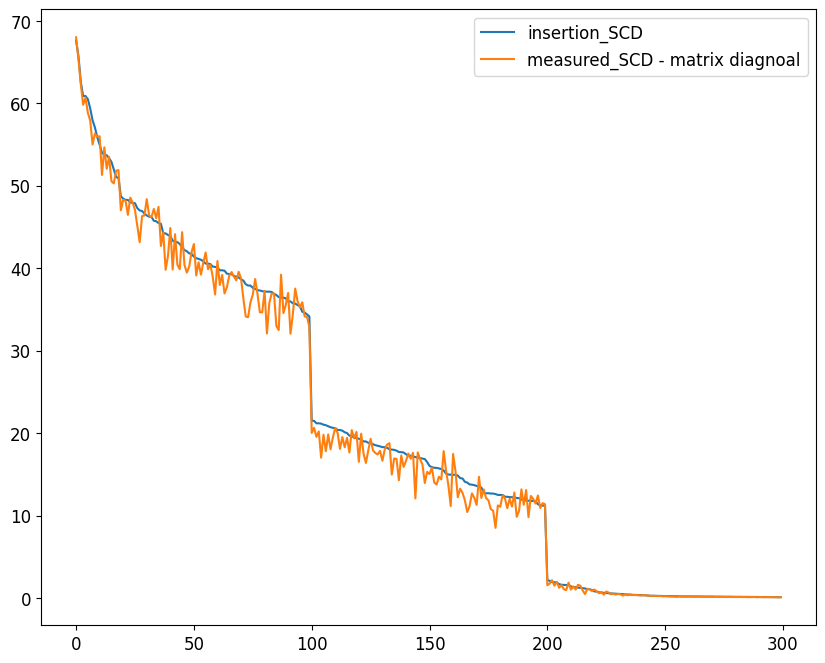

In [4]:
plt.figure(figsize=(10,8))
x = [x for x in range(300)]

plt.plot(x, df_sorted[df_sorted["start_core"] == 37357852].insertion_SCD_flank, label="insertion_SCD")
plt.plot(x, np.diag(MATRIX), label="measured_SCD - matrix diagnoal")

plt.legend()

### Checking how the values drop along rows

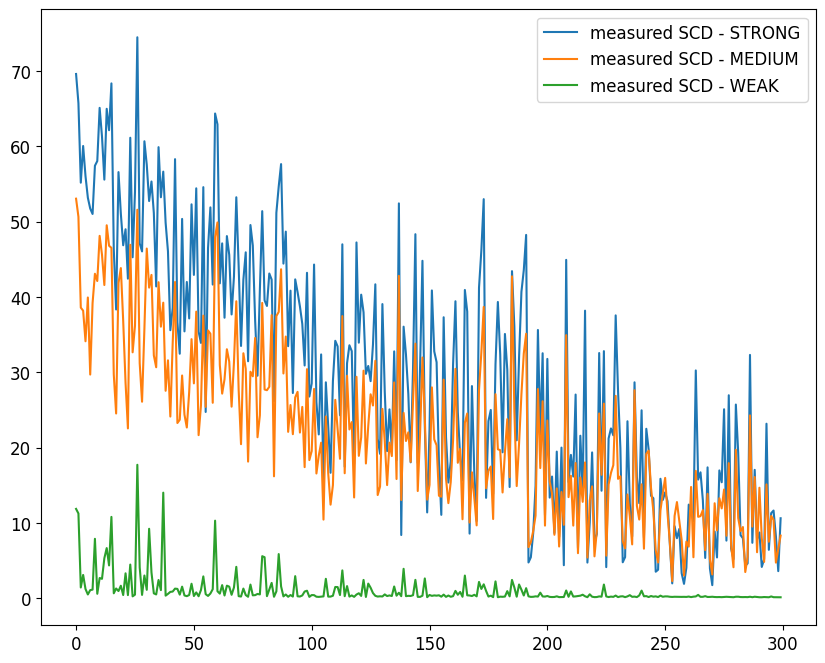

In [5]:
plt.figure(figsize=(10,8))
x = [x for x in range(300)]

plt.plot(x, MATRIX[50,:], label="measured SCD - STRONG")
plt.plot(x, MATRIX[150,:], label="measured SCD - MEDIUM")
plt.plot(x, MATRIX[250,:], label="measured SCD - WEAK")

plt.legend()

In [6]:
# set up global color scale
global_vmin = 0
global_vmax = 95

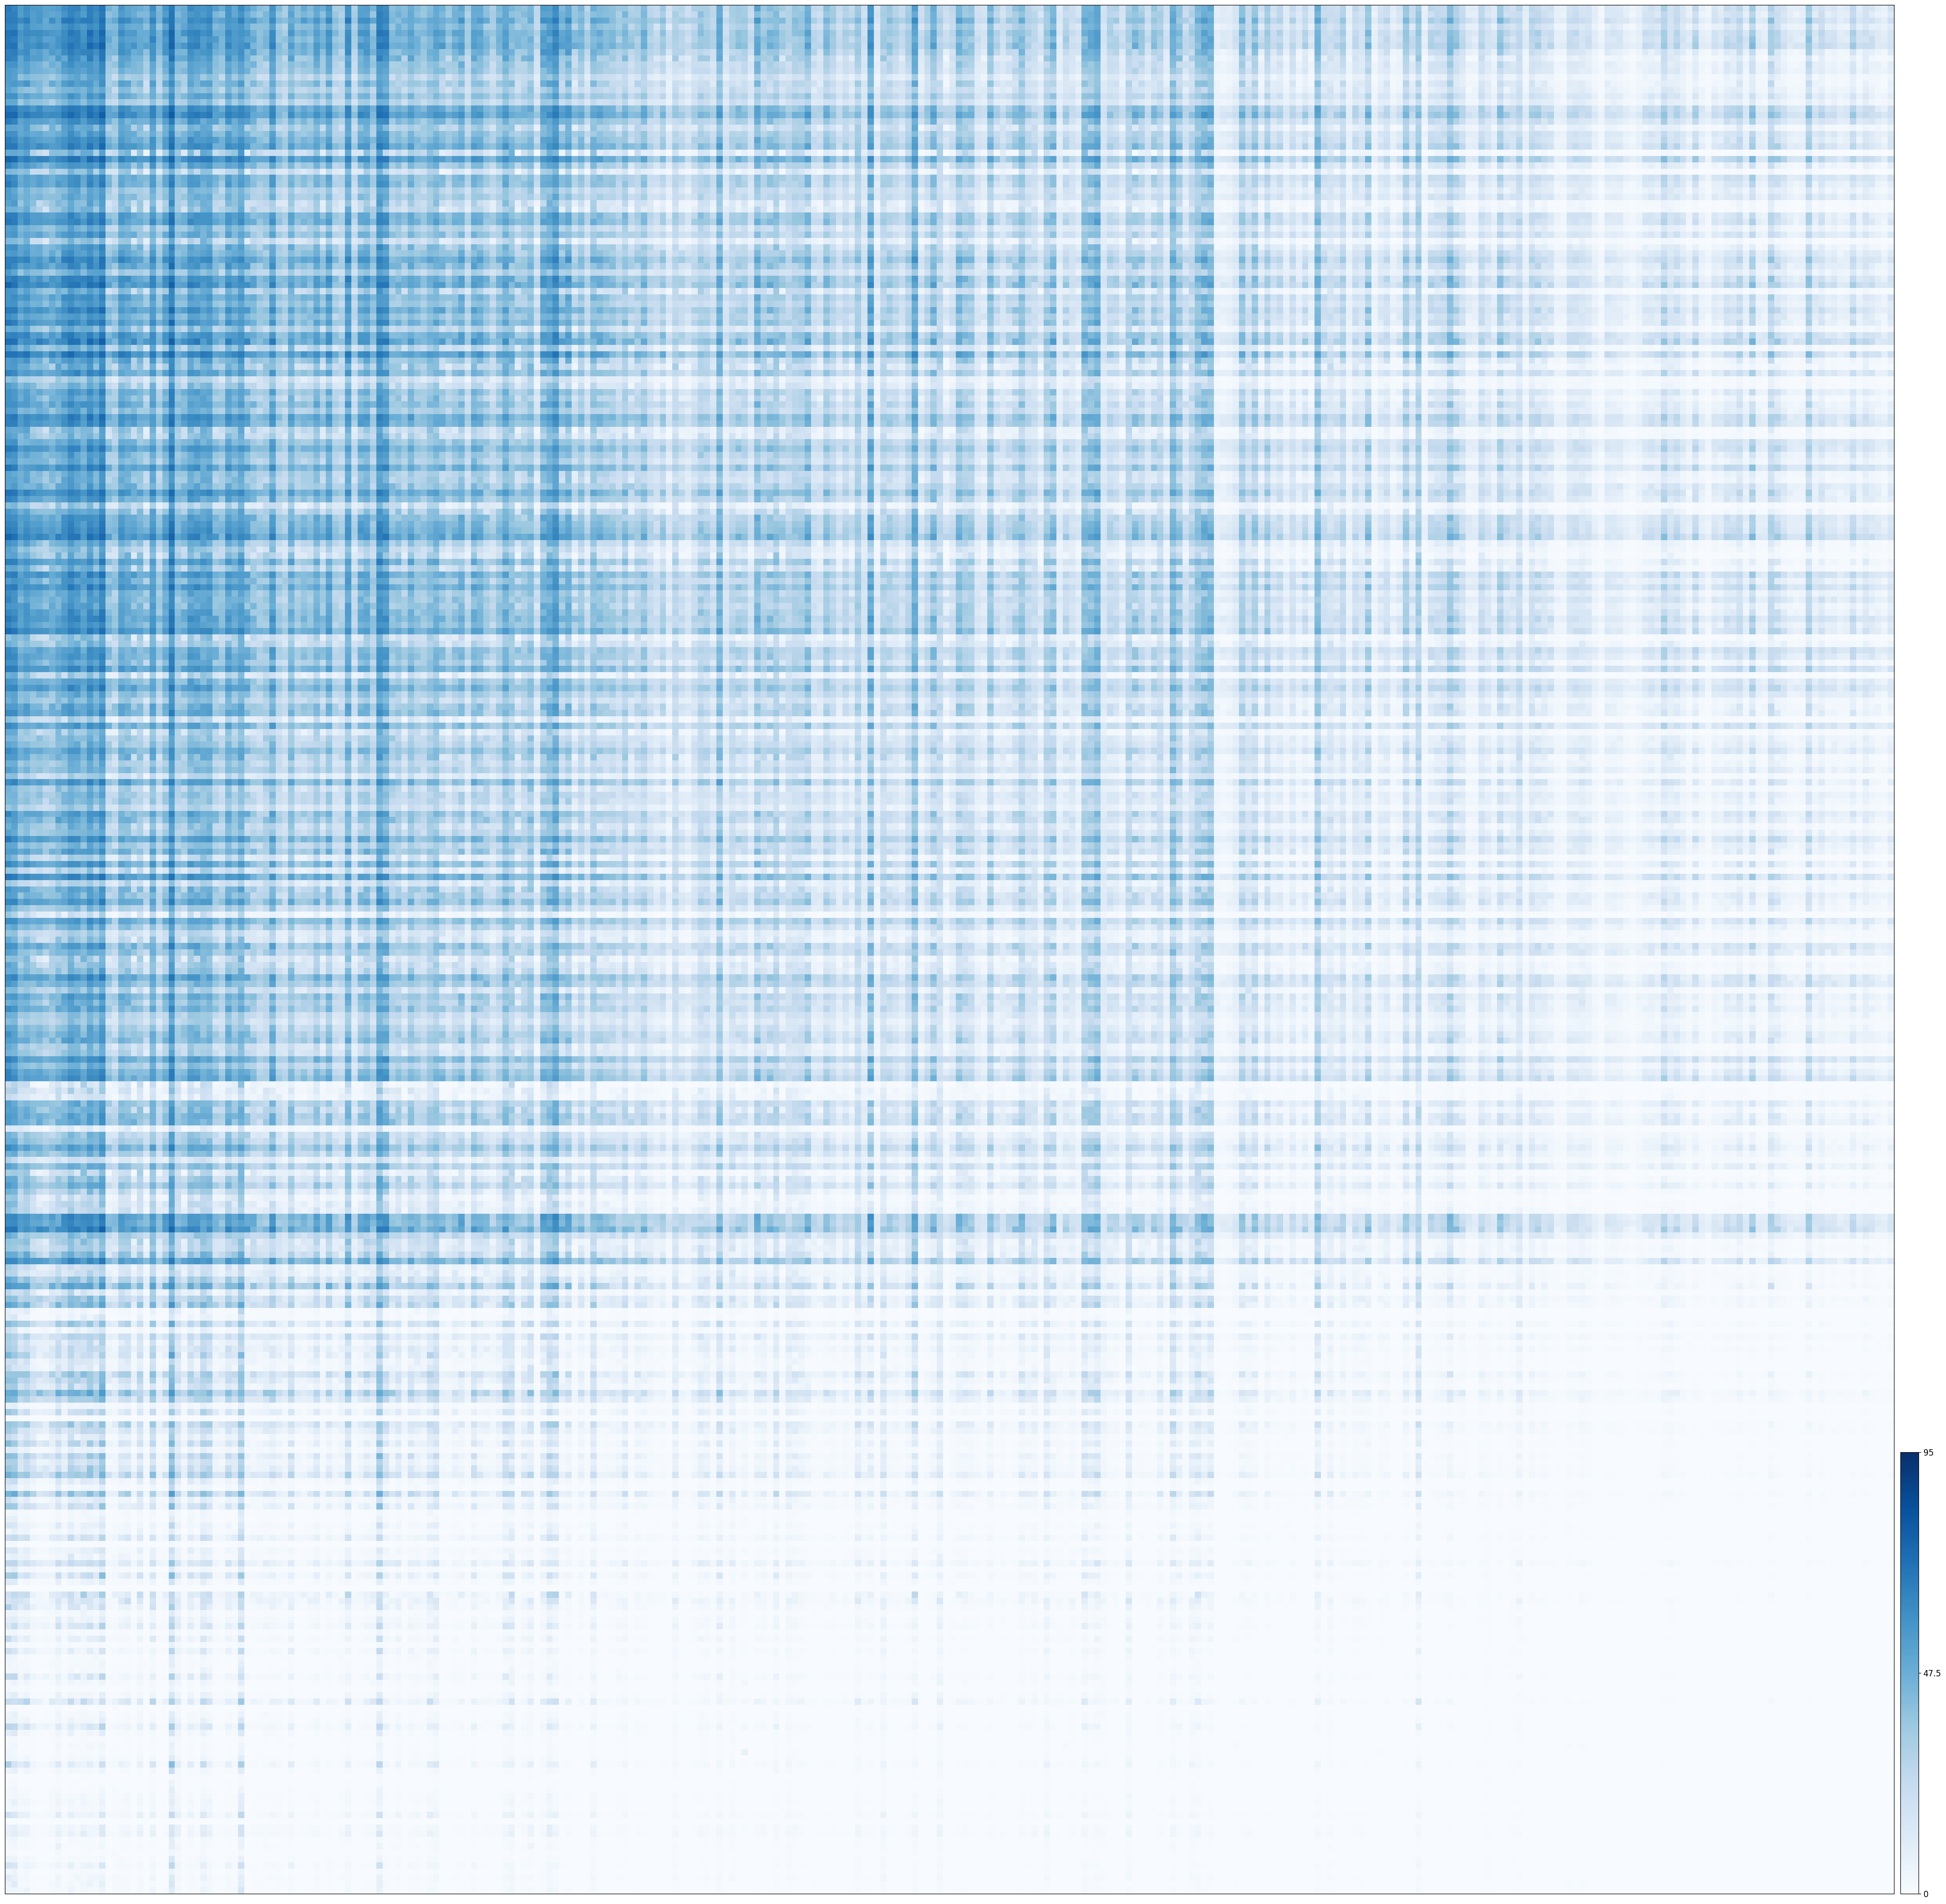

In [7]:
fig, ax = plt.subplots()
# colormap = "YlOrBr"
colormap = "Blues"
im = ax.imshow(MATRIX, cmap=colormap, vmin=global_vmin, vmax=global_vmax)

fig.set_figheight(50)
fig.set_figwidth(50)

cax = plt.axes([0.90, 0.110, 0.0075, 0.18])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=colormap), cax=cax, ticks=[0, 0.5, 1])

# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])

cbar.ax.set_yticklabels([str(global_vmin), 
                         str(round(((global_vmax - global_vmin)/2),1)), 
                         str(global_vmax)])

# Draw vertical and horizontal lines to divide the matrix into 9 equal parts
# for line_position in [100, 200]:
#     ax.axvline(x=line_position - 0.5, color='black', linewidth=20)  # Adjust line color/width as needed
#     ax.axhline(y=line_position - 0.5, color='black', linewidth=20)  # Adjust line color/width as needed

# plt.savefig("./plots/core_flank_compatibility_matrix.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Summary Plot

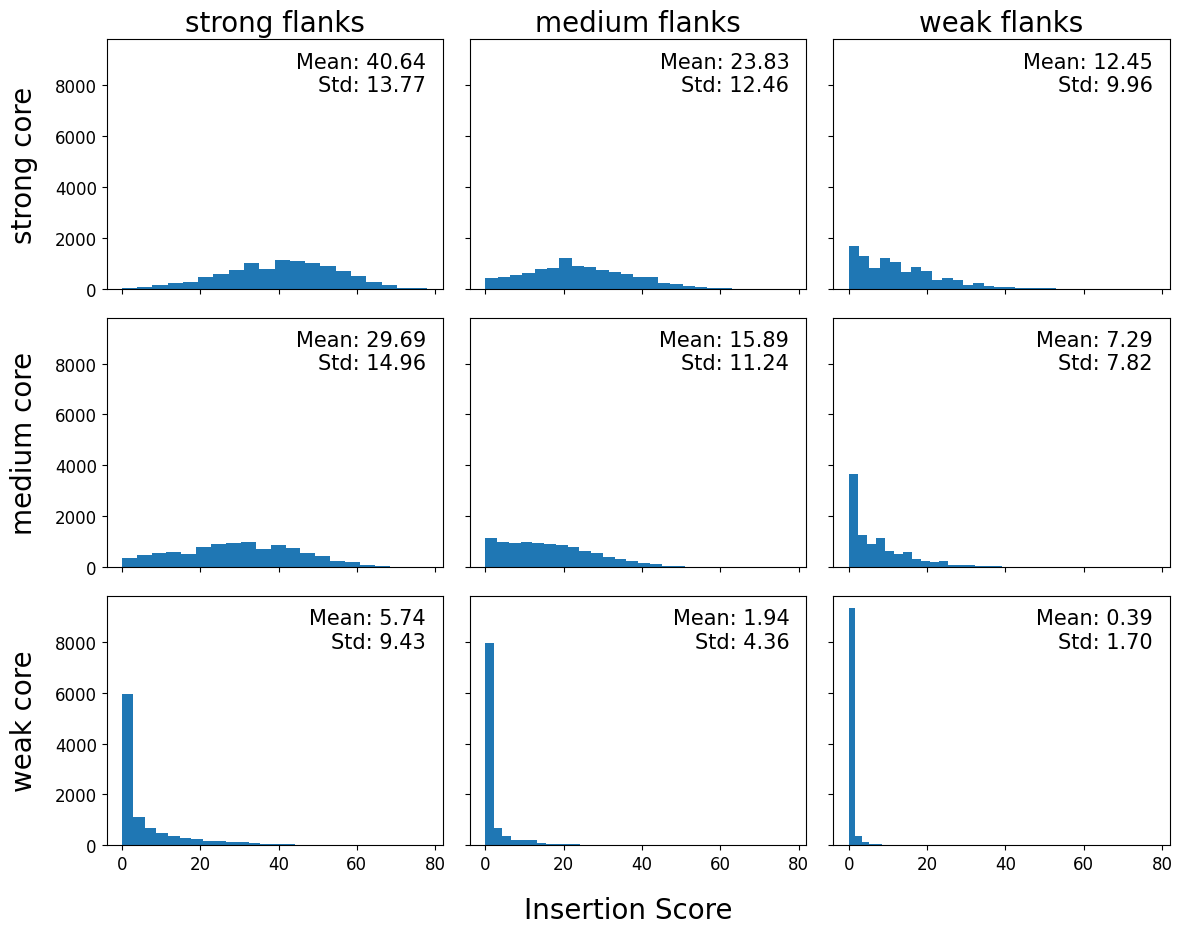

In [8]:
fig, axs = plt.subplots(3, 3, sharey=True, sharex=True, tight_layout=True, figsize=(12, 9))

num_bins = 20

# Data segments
segments = [
    (0, 100, 0, 100),   # strong core, strong flanks
    (0, 100, 100, 200), # strong core, medium flanks
    (0, 100, 200, 300), # strong core, weak flanks
    (100, 200, 0, 100), # medium core, strong flanks
    (100, 200, 100, 200),# medium core, medium flanks
    (100, 200, 200, 300),# medium core, weak flanks
    (200, 300, 0, 100), # weak core, strong flanks
    (200, 300, 100, 200),# weak core, medium flanks
    (200, 300, 200, 300) # weak core, weak flanks
]

# Plot histograms and calculate mean & std, then annotate
for (i, j), (r_start, r_end, c_start, c_end) in zip(np.ndindex(axs.shape), segments):
    data = MATRIX[r_start:r_end, c_start:c_end].flatten().astype(int)
    mean = data.mean()
    std = data.std()
    
    axs[i, j].hist(data, bins=num_bins)
    axs[i, j].text(0.95, 0.95, f'Mean: {mean:.2f}\nStd: {std:.2f}', transform=axs[i, j].transAxes,
                   verticalalignment='top', horizontalalignment='right', fontsize=15)

cols = ["strong flanks", "medium flanks", "weak flanks"]
rows = ["strong core", "medium core", "weak core"]

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=20, labelpad=12)

# Adding a common X-axis label
fig.text(0.53, -0.03, 'Insertion Score', ha='center', fontsize=20)

plt.show()

### Displaying separately the diagonal (cognate core-flank combinations)

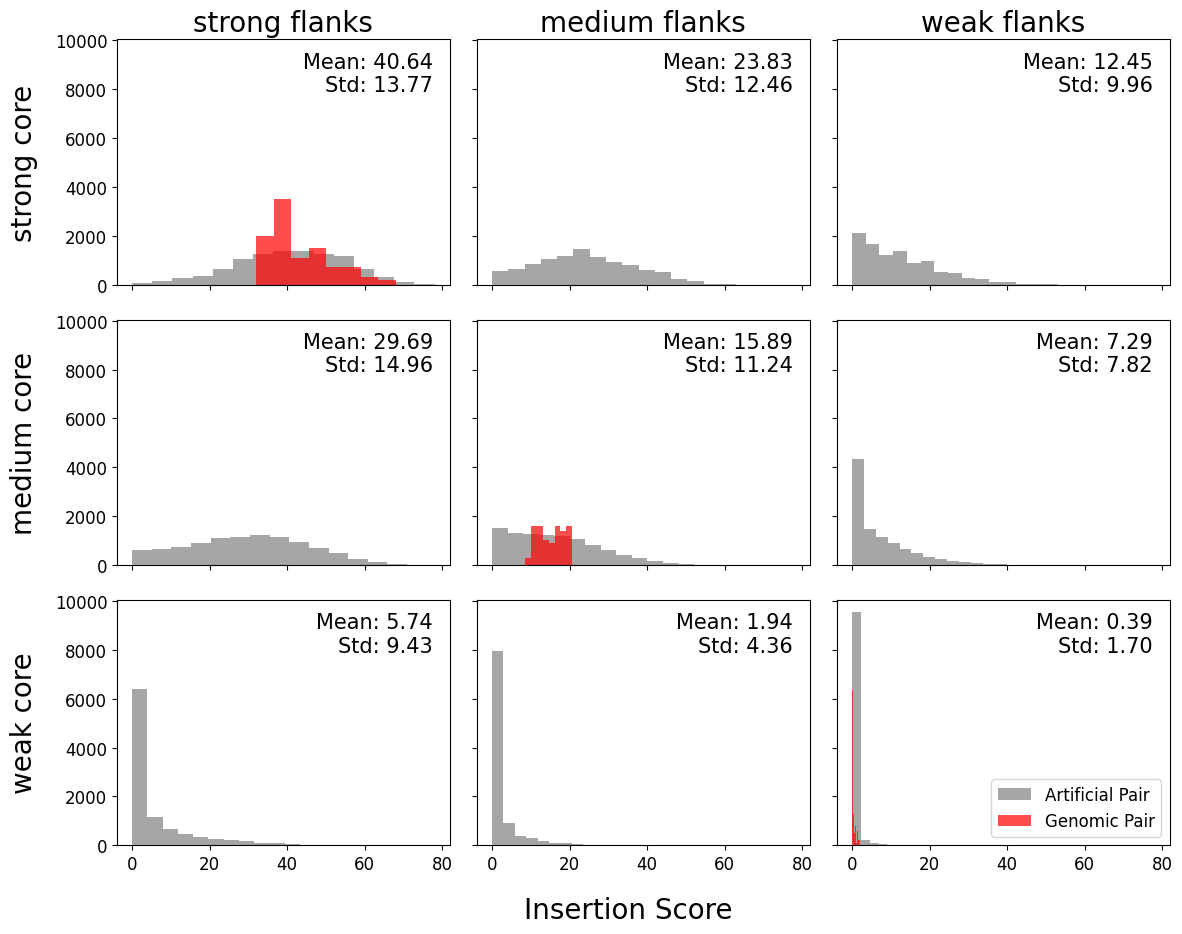

In [9]:
fig, axs = plt.subplots(3, 3, sharey=True, sharex=True, tight_layout=True, figsize=(12, 9))
num_bins_nondiag = 15
num_bins_diag = 8

# Data segments
segments = [
    (0, 100, 0, 100),   # strong core, strong flanks
    (0, 100, 100, 200), # strong core, medium flanks
    (0, 100, 200, 300), # strong core, weak flanks
    (100, 200, 0, 100), # medium core, strong flanks
    (100, 200, 100, 200),# medium core, medium flanks
    (100, 200, 200, 300),# medium core, weak flanks
    (200, 300, 0, 100), # weak core, strong flanks
    (200, 300, 100, 200),# weak core, medium flanks
    (200, 300, 200, 300) # weak core, weak flanks
]

diag_indices = np.arange(100)

for (i, j), (r_start, r_end, c_start, c_end) in zip(np.ndindex(axs.shape), segments):
    # Extract the full segment
    matrix_chunk = MATRIX[r_start:r_end, c_start:c_end]
    full_data = matrix_chunk.flatten().astype(int)

    mean = full_data.mean()
    std = full_data.std()
    
    # Identify and separate the diagonal if it's a square segment (for core regions)
    if (r_end == c_end) and (r_start == c_start):
        diag_values = np.diag(MATRIX)[r_start:r_end]
        # masking diagonal
        mask = np.eye(matrix_chunk.shape[0], dtype=bool)
        non_diag_data = np.ma.masked_array(matrix_chunk, mask).flatten().astype(int)
        # non_diag_data = np.delete(np.delete(matrix_chunk, diag_indices, axis=0), diag_indices, axis=1)
        # non_diag_data = non_diag_data.flatten().astype(int)
    else:
        non_diag_data = full_data
        diag_values = []
    
    # Plot histogram for non-diagonal data
    axs[i, j].hist(non_diag_data, bins=num_bins_nondiag, label='Artificial Pair', color='grey', alpha=0.7)
    
    if (r_end == c_end) and (r_start == c_start):
        _weights = np.ones((100)) * 100
        axs[i, j].hist(diag_values, bins=num_bins_diag, weights=_weights, color='red', alpha=0.7, label='Genomic Pair')
    
    # Annotation for mean and std
    axs[i, j].text(0.95, 0.95, f'Mean: {mean:.2f}\nStd: {std:.2f}', transform=axs[i, j].transAxes,
                   verticalalignment='top', horizontalalignment='right', fontsize=15)

# Setting titles and labels as before
cols = ["strong flanks", "medium flanks", "weak flanks"]
rows = ["strong core", "medium core", "weak core"]
for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=20, labelpad=12)
fig.text(0.53, -0.03, 'Insertion Score', ha='center', fontsize=20)

# Optionally, display a legend in the first subplot to explain colors
axs[2, 2].legend(loc='lower right')

# plt.savefig("./plots/core_flank_compatibility_summary.pdf", format="pdf", bbox_inches="tight")
plt.show()

### SVD Analysis

In [10]:
U, Sigma, VT = np.linalg.svd(MATRIX.astype(int))

# Extract the first singular value and vectors for rank-1 approximation
sigma1 = Sigma[0]
u1 = U[:, 0]
v1 = VT.T[:, 0]

# Rank-1 approximation of A
A_approx = sigma1 * np.outer(u1, v1)

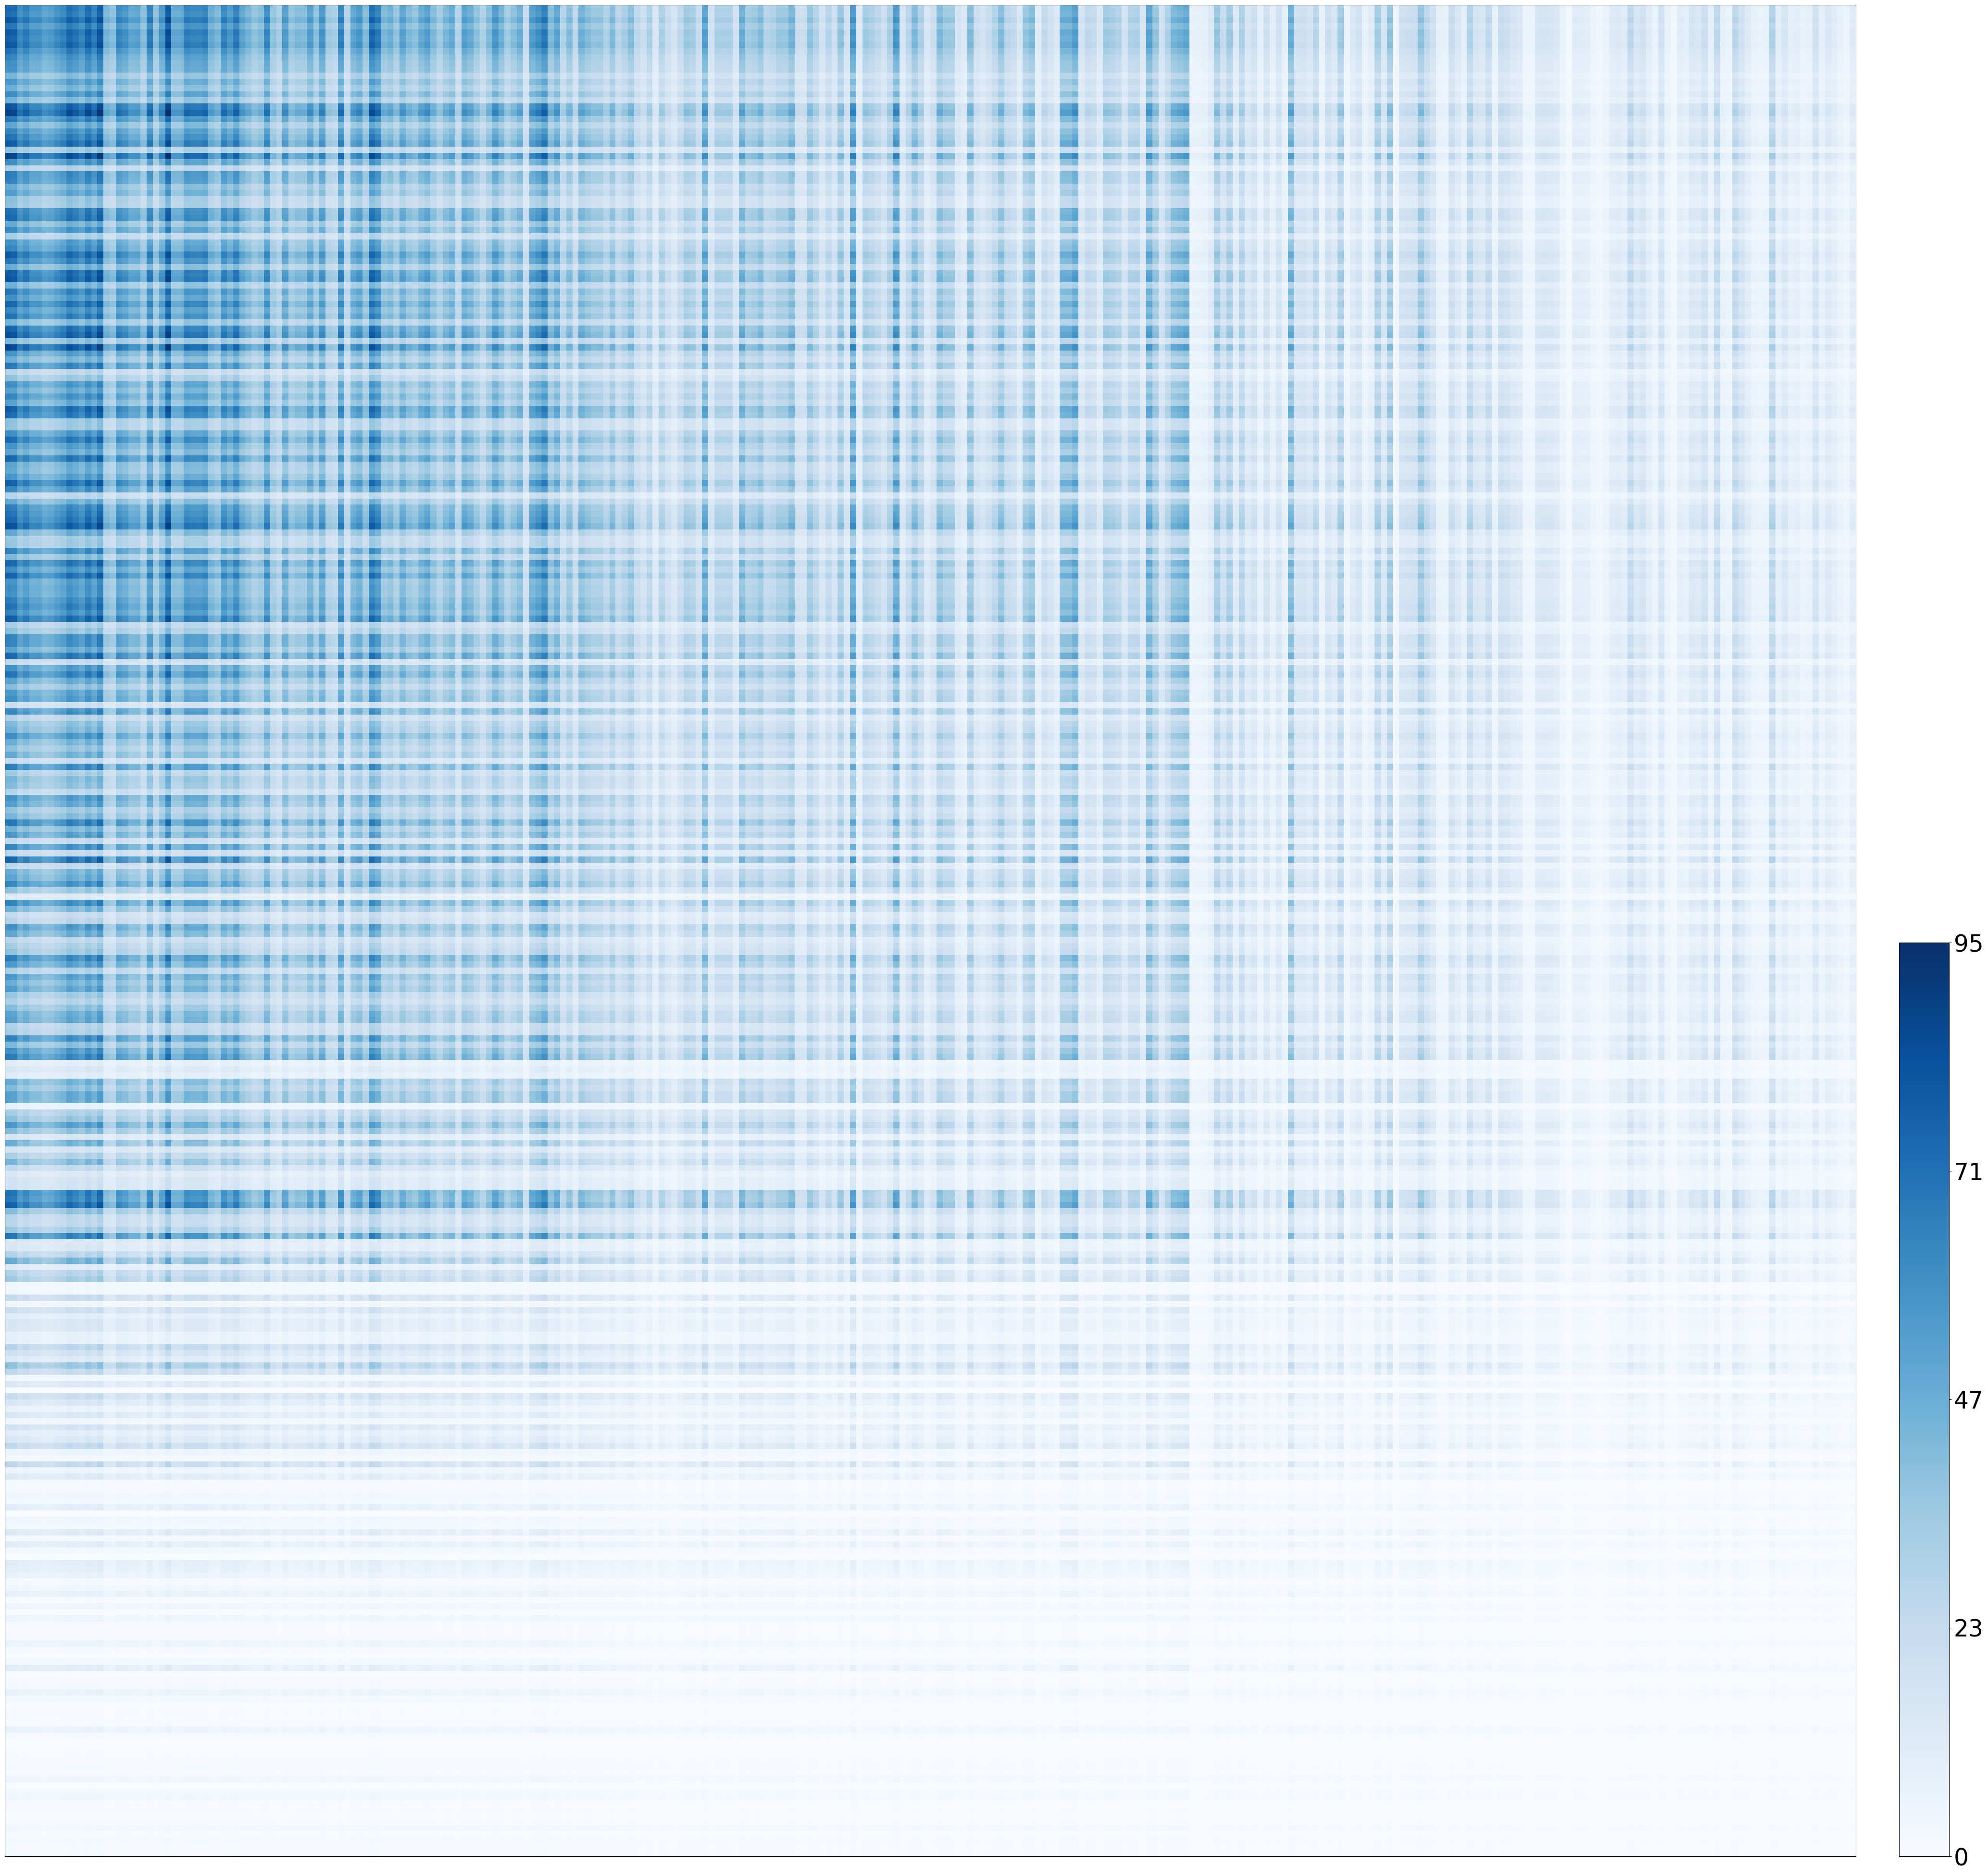

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(A_approx, cmap=colormap, vmin=global_vmin, vmax=global_vmax)

fig.set_figheight(50)
fig.set_figwidth(52)

cax = plt.axes([0.90, 0.110, 0.02, 0.38])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=colormap), cax=cax, ticks=[0, 0.25, 0.5, 0.75, 1])

# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])

cbar.ax.set_yticklabels([str(global_vmin), 
                         str(int(((global_vmax - global_vmin)*0.25))),
                         str(int(((global_vmax - global_vmin)/2))), 
                        str(int(((global_vmax - global_vmin)*0.75))),
                         str(global_vmax)], fontsize=35)

# for line_position in [100, 200]:
#     ax.axvline(x=line_position - 0.5, color='black', linewidth=20)  # Adjust line color/width as needed
#     ax.axhline(y=line_position - 0.5, color='black', linewidth=20)  # Adjust line color/width as needed

# plt.savefig("./plots/core_flank_compatibility_SVD.pdf", format="pdf", bbox_inches="tight")
plt.show()

### The difference between predicted and approximated matrices

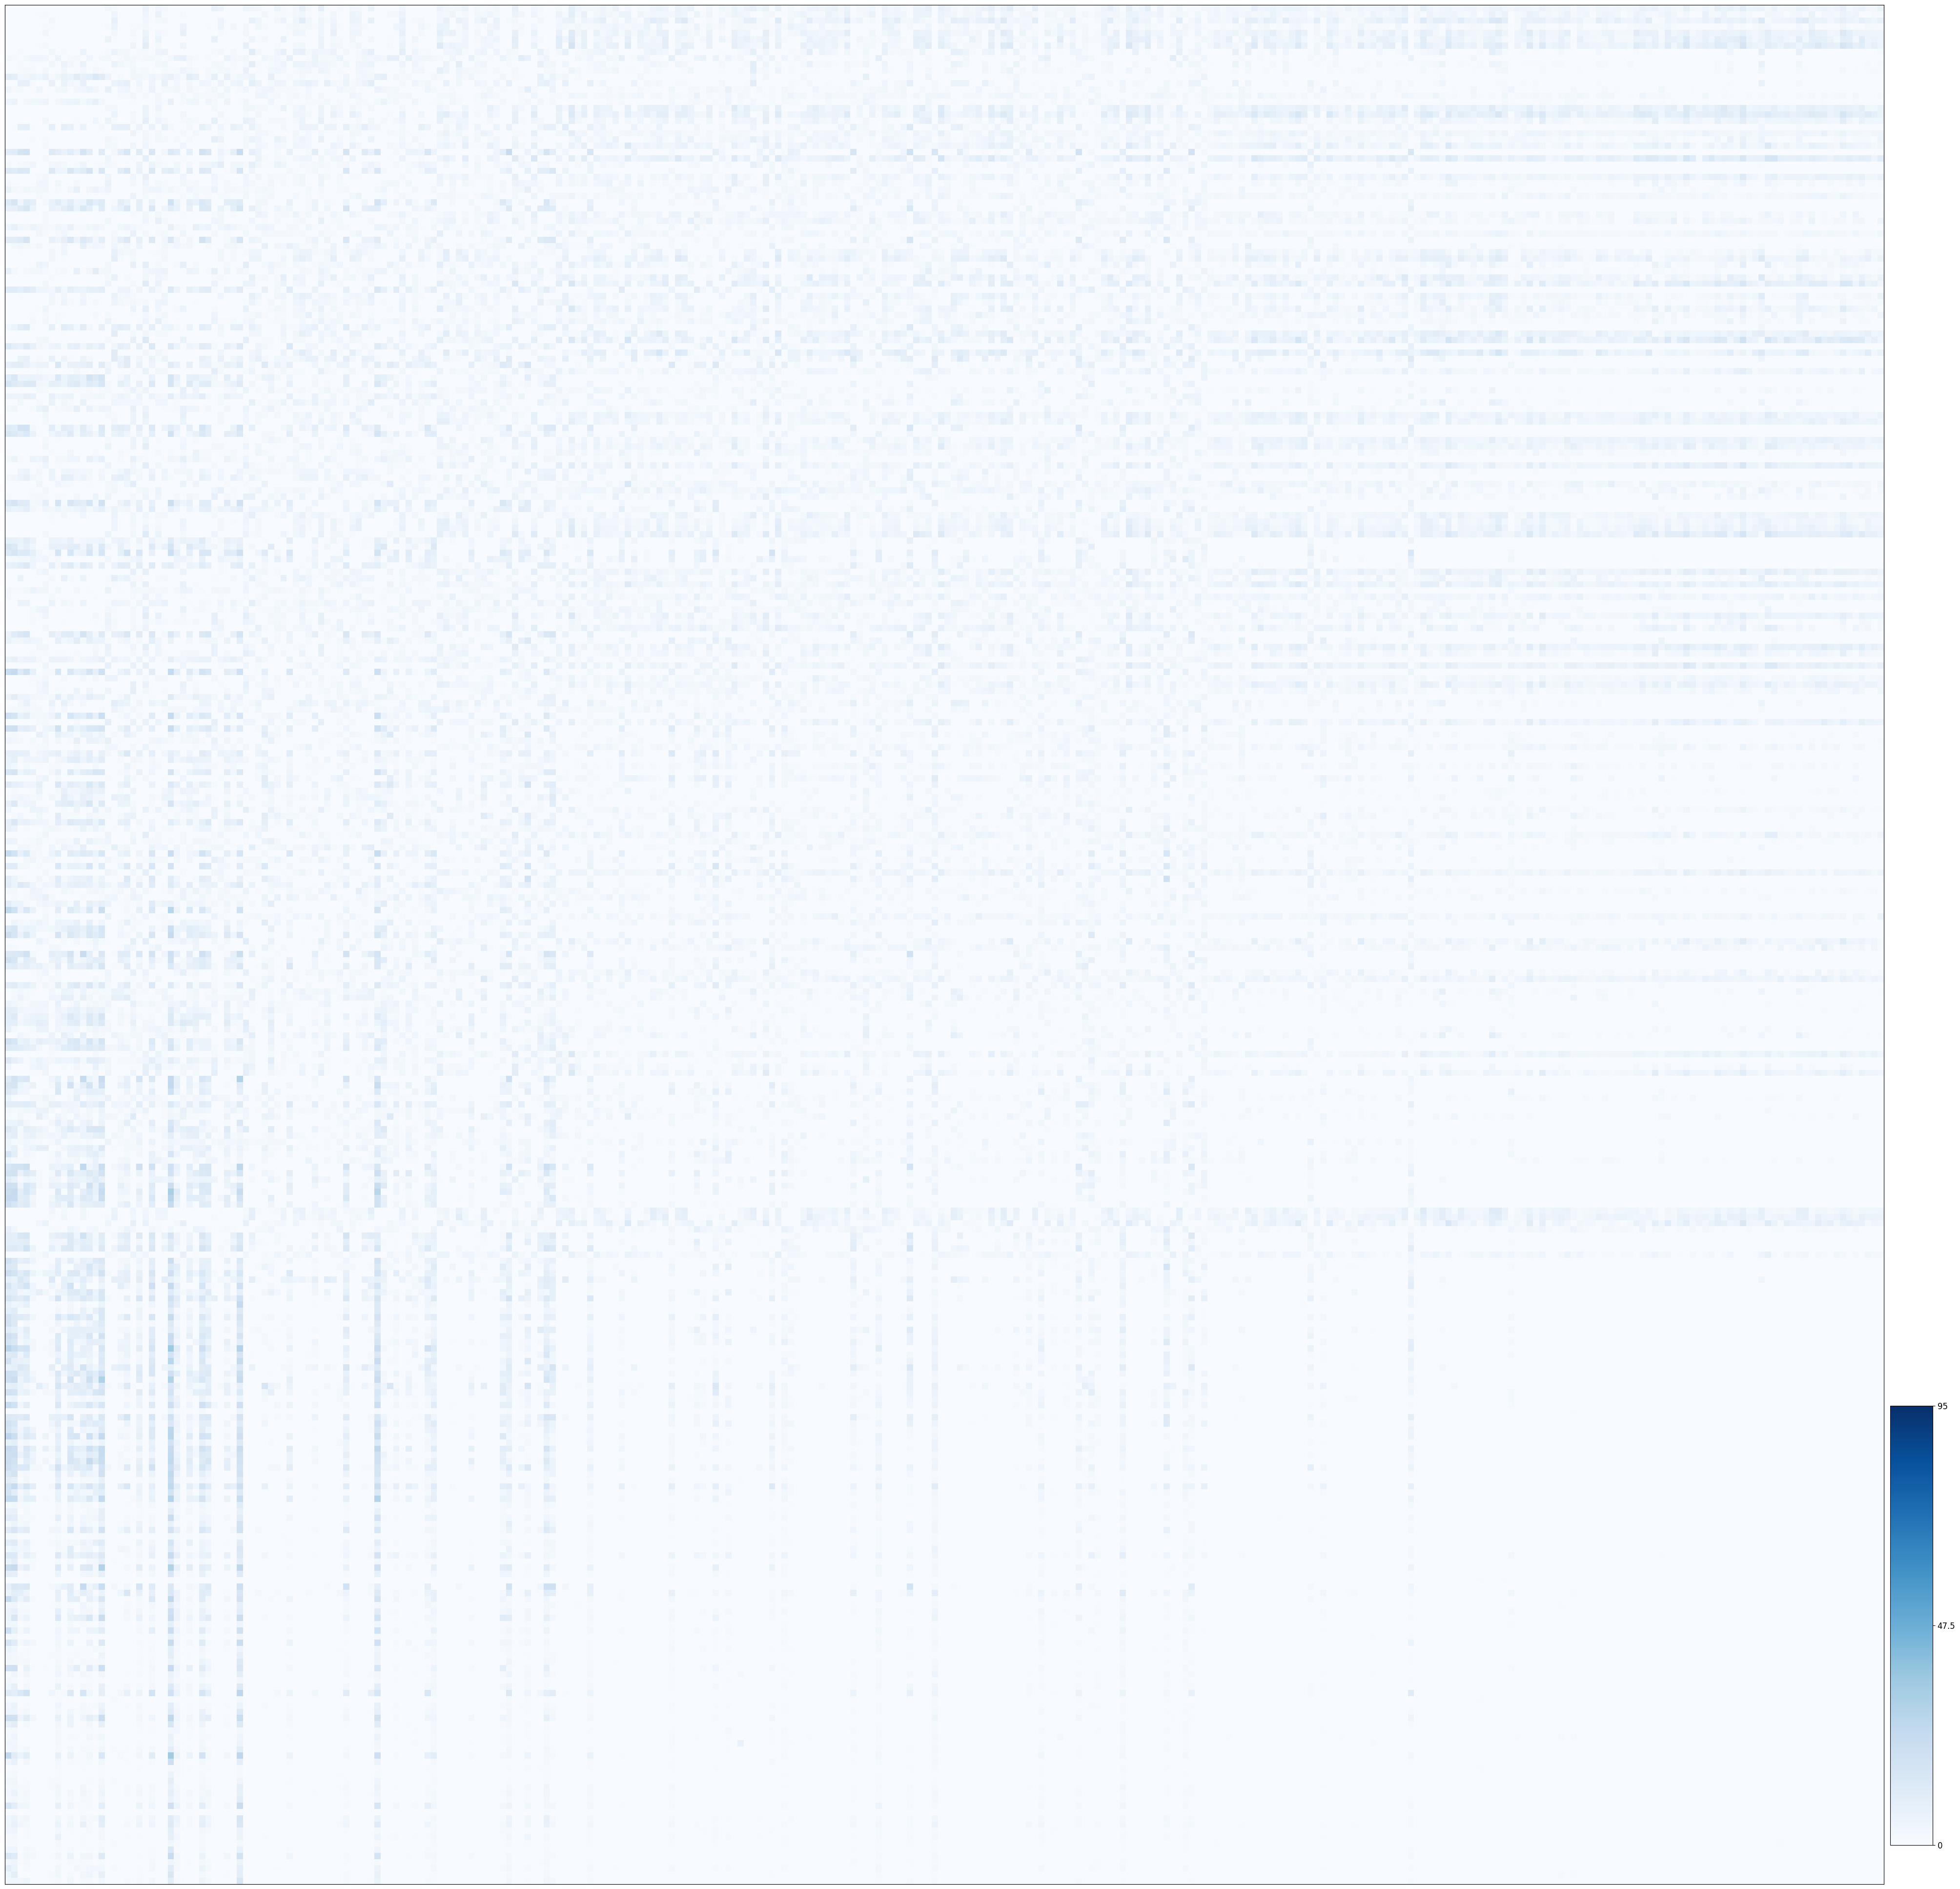

In [12]:
fig, ax = plt.subplots()
im = ax.imshow(MATRIX-A_approx, cmap=colormap, vmin=global_vmin, vmax=global_vmax)

fig.set_figheight(50)
fig.set_figwidth(50)

cax = plt.axes([0.90, 0.126, 0.0175, 0.18])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=colormap), cax=cax, ticks=[0, 0.5, 1])

# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])

cbar.ax.set_yticklabels([str(global_vmin), 
                         str(round(((global_vmax - global_vmin)/2),1)), 
                         str(global_vmax)])
plt.show()

### Scatterplot of observed vs. expected

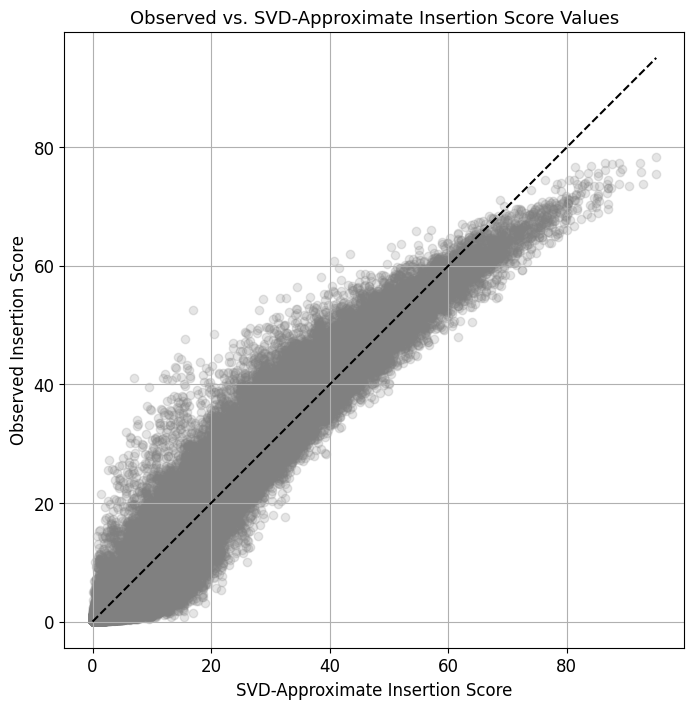

In [13]:
obs_values = MATRIX.flatten()
pred_values = (A_approx).flatten()

# Create a scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(pred_values, obs_values, color='grey', alpha=0.2)
plt.title('Observed vs. SVD-Approximate Insertion Score Values')
plt.ylabel('Observed Insertion Score')
plt.xlabel('SVD-Approximate Insertion Score')
plt.grid(True)

# Add a line representing perfect correlation (y = x)
max_val = max(np.max(obs_values), np.max(pred_values))
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--')

# Ensure the plot is square by setting equal aspect ratio
plt.axis('equal')

# plt.savefig("./plots/observed_vs_expected.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Showing correlation between averaged insertion score for cores and flanks and singular vectors

In [14]:
# Calculate the average strength of each core (row averages)
row_averages = np.mean(MATRIX, axis=1)

# Calculate the average strength of each flanking sequence (column averages)
column_averages = np.mean(MATRIX, axis=0)

Text(0.5, 0, 'row_averages')

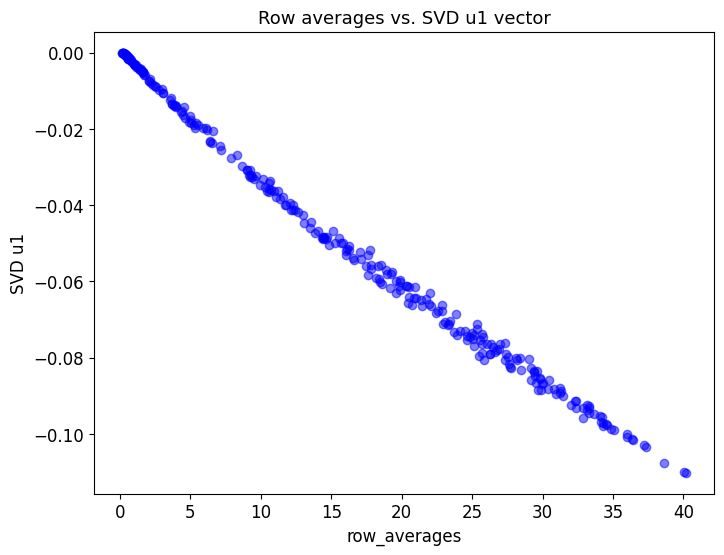

In [16]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(row_averages, u1, color='blue', alpha=0.5)
plt.title('Row averages vs. SVD u1 vector')
plt.ylabel('SVD u1')
plt.xlabel('row_averages')

Text(0.5, 0, 'column_averages')

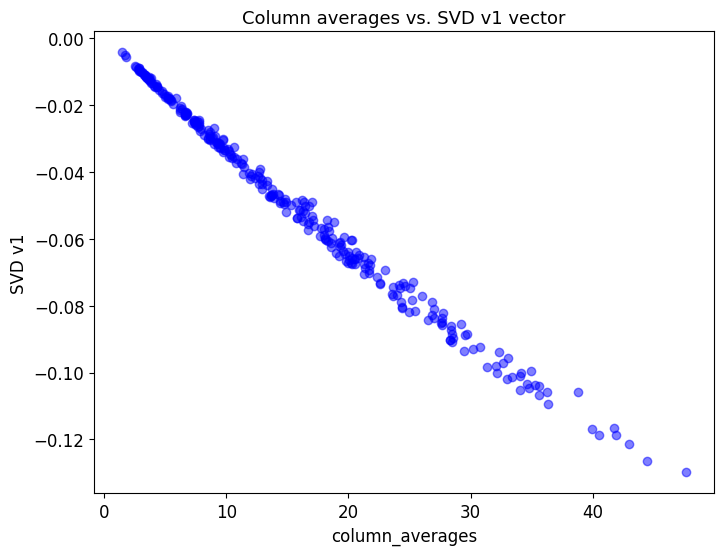

In [17]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(column_averages, v1, color='blue', alpha=0.5)
plt.title('Column averages vs. SVD v1 vector')
plt.ylabel('SVD v1')
plt.xlabel('column_averages')